In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import expipe
import os
import pathlib
import numpy as np
import exdir
import pandas as pd
import optogenetics as og
import quantities as pq
import shutil
from distutils.dir_util import copy_tree
import seaborn as sns
import pycwt
from septum_mec.analysis.stimulus_response import stimulus_response_latency, compute_response
from septum_mec.analysis.plotting import despine
from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from septum_mec.analysis.statistics import load_data_frames

tqdm_notebook.pandas()

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [3]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (2.5, 2), 
    'figure.dpi': 150
})

In [4]:
df, labels, colors, queries = load_data_frames()
gc_ns_df = df.query("ns_inhibited or gridcell")
# remove sampeles which are both GC and NSi using xor
gc_ns_df = gc_ns_df.query("not (ns_inhibited and gridcell)")

Number of sessions above threshold 194
Number of animals 4
Number of individual gridcells 139
Number of gridcell recordings 230


### Compute pairs and make new dataframe

In [5]:
# add drive
drives = []
for i, row in gc_ns_df.iterrows():
    if row.channel_group < 4:
        drives.append(0)
    else:
        drives.append(1)
gc_ns_df["drive"] = drives

In [6]:
# groupby action and channel groups
actions = []
channel_groups_gc = []
channel_groups_ns = []
drives = []
pairs = []
t_e_minus_t_is = []
for gp, df in gc_ns_df.groupby(["action", "drive"]):
    gridcells = df.query("gridcell")
    narrows = df.query("ns_inhibited")
#     print(f"Action: {gp[0]} - group: {gp[1]} - n GCs: {len(gridcells)} - n NSi: {len(narrows)}")
    if len(gridcells) > 0 and len(narrows) > 0:
        for i, gc in gridcells.iterrows():
            for j, ns in narrows.iterrows():
                pair = [gc.unit_id, ns.unit_id]
                pairs.append(pair)
                drives.append(gc.drive)
                actions.append(gp[0])
                channel_groups_gc.append(gc.channel_group)
                channel_groups_ns.append(ns.channel_group)
                t_e_minus_t_is.append(gc.t_e_peak - ns.t_i_peak)
pair_df = pd.DataFrame(data={"action": actions, "drive": drives, "channel_groups_gc": channel_groups_gc, "channel_groups_ns": channel_groups_ns, "pair": pairs, "peak_diff": t_e_minus_t_is})

In [7]:
pair_df = pair_df.dropna()

In [8]:
pair_df

,action,drive,channel_groups_gc,channel_groups_ns,pair,peak_diff
9,1833-010719-2,0,1,3,"[a10ac2a1-89f9-4cb5-9f76-4a230cf99324, 9141d07...",0.0042
10,1833-010719-2,0,1,3,"[69198e70-febc-474a-9bc0-7d8c6ca2a427, 9141d07...",0.0045
11,1833-010719-2,0,1,3,"[66301701-ec31-4aa0-ba74-141388040dbf, 9141d07...",0.0031
12,1833-010719-2,0,2,3,"[9fde0cc8-463f-4910-a35a-a0f86ff67180, 9141d07...",0.0042
13,1833-010719-2,0,3,3,"[504abe70-271e-408d-bd31-4da23abf47e8, 9141d07...",0.0029
...,...,...,...,...,...,...
202,1839-200619-2,1,6,6,"[c84ea3a1-54dd-4b77-b8f3-d3786a55aa75, 7f37a0c...",0.0025
204,1849-150319-4,1,4,4,"[790e90ac-d9fc-4195-be35-996837305024, 804cf23...",0.0068
205,1849-220319-3,0,0,1,"[3f821594-6d3b-4d3e-b07c-e0b44adfd8eb, c78635a...",0.0042
206,1849-280219-2,1,7,4,"[2923d2c9-f50e-44d0-8ee9-1ce8777c2c05, 18e8a58...",0.0064


(array([19., 37., 35., 16.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([0.002  , 0.00298, 0.00396, 0.00494, 0.00592, 0.0069 , 0.00788,
        0.00886, 0.00984, 0.01082, 0.0118 , 0.01278, 0.01376, 0.01474,
        0.01572, 0.0167 , 0.01768, 0.01866, 0.01964, 0.02062, 0.0216 ]),
 <a list of 20 Patch objects>)

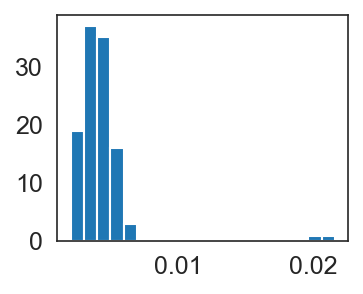

In [9]:
plt.hist(pair_df.peak_diff, bins=20)

In [13]:
pair_df.peak_diff.mean(), pair_df.peak_diff.sem()

(0.004249107142857143, 0.0002307902723951557)

In [10]:
output = pathlib.Path('output/response-pairwise-comparison')
(output / 'figures').mkdir(parents=True, exist_ok=True)

# Save to expipe

In [11]:
action = project.require_action("stimulus-response")

NameError: name 'project' is not defined

In [ ]:
copy_tree(output, str(action.data_path()))

In [ ]:
septum_mec.analysis.registration.store_notebook(action, "10-calculate-stimulus-response.ipynb")